In [1]:
%matplotlib notebook

# Creating a Reader

**Suhas Somnath, Sudhajit Misra**

10/9/2020

This document illustrates an example of extracting data and metadata out of proprietary raw
data files, thereby describing how one would write a ``sidpy.Reader`` class.

The captured information would be populated into a / set of ``sidpy.Dataset``
object(s) as appropriate.

## Introduction
In most scientific disciplines, commercial instruments tend to write the data and metadata out into proprietary file
formats that significantly impede access to the data and metadata, thwart sharing of data and correlation of data from
multiple instruments, and complicate long-term archival, among other things. One of the data wrangling steps in science
is the extraction of the data and metadata out of the proprietary file formats and writing the information into files
that are easier to access, share, etc. The overwhelming part of this data wrangling effort is in investigating how to
extract the data and metadata into memory. Often, the data and parameters in these files are **not** straightforward to
access. In certain cases, additional / dedicated software packages are necessary to access the data while in many other
cases, it is possible to extract the necessary information from built-in **numpy** or similar python packages included
with **anaconda**. Once the information is accessible in the computer memory, such as in the
form of numpy arrays, scientists have a wide variety of tools to write the data out into files.

Simpler data such as images or single spectra can easily be written into plain text files. Simple or complex / large /
multidimensional data can certainly be stored as numpy data files. However, there are significant drawbacks to writing
data into non-standardized structures or file formats. First, while the structure of the data and metadata may be
intuitive for the original author of the data, that may not be the case for another researcher. Furthermore, such
formatting may change from a day-to-day basis. As a consequence, it becomes challenging to develop code that can accept
such data whose format keeps changing.

One solution to these challenges is to write the data out into standardized files such as ``h5USID`` files.
The USID model aims to make data access, storage, curation, etc. simply by storing the data along with all
relevant parameters in a single file (HDF5 for now).

The process of copying data from the original format to **h5USID** files is called
**Translation** and the classes available in pyUSID and children packages such as pycroscopy that perform these
operation are called **Translators**.

As we alluded to earlier, the process of developing a ``sidpy.Reader`` can be
broken down into two basic components:

1. Extracting data and metadata out of the proprietary file format
2. Populating one or more ``sidpy.Dataset`` objects as necessary

This process is the same regardless of the origin, complexity, or size of the scientific data. It is not necessary that
the two components be disjoint - there are many situations where both components may need to happen simultaneously
especially when the data sizes are very large.

The goal of this document is to demonstrate how one would extract data and parameters from a raw data file. For the purposes of demonstration, we use Scanning Tunnelling Spectroscopy (STS) raw data file obtained from an Omicron Scanning Tunneling Microscope (STM).
In this dataset, a spectra was collected for each position in a two-dimensional grid of spatial locations, thereby
resulting in a 3D dataset.

The code in this example is an abbreviation of the
`AscTranslator <https://github.com/pycroscopy/pycroscopy/blob/master/pycroscopy/io/translators/omicron_asc.py>`_
available in our sister package - `pycroscopy`.

### Recommended pre-requisite reading

Before proceeding with this example, we recommend learning about ``Sidpy.Reader``:

.. tip::
    You can download and run this document as a Jupyter notebook using the link at the bottom of this page.

### Import all necessary packages
There are a few setup procedures that need to be followed before any code is written. In this step, we simply load a
few python packages that will be necessary in the later steps.

In [2]:
# Ensure python 3 compatibility:
from __future__ import division, print_function, absolute_import, unicode_literals

# The package for accessing files in directories, etc.:
import os
import zipfile


# Warning package in case something goes wrong
from warnings import warn
import subprocess
import sys

def install(package):
    subprocess.call([sys.executable, "-m", "pip", "install", package])
# Package for downloading online files:
try:
    # This package is not part of anaconda and may need to be installed.
    import wget
except ImportError:
    warn('wget not found.  Will install with pip.')
    import pip
    install(wget)
    import wget

# The mathematical computation package:
import numpy as np

# The package used for creating and manipulating HDF5 files:
import h5py

# Packages for plotting:
import matplotlib.pyplot as plt

# import sidpy - supporting package for creating Dataset object:
try:
    import sidpy
except ImportError:
    warn('sidpy not found.  Will install with pip.')
    import pip
    install('sidpy')
    import sidpy

### Procure the Raw Data file

Here we will download a compressed data file from Github and unpack it:

In [3]:
url = 'https://raw.githubusercontent.com/pycroscopy/pyUSID/master/data/STS.zip'
zip_path = 'STS.zip'
if os.path.exists(zip_path):
    os.remove(zip_path)
_ = wget.download(url, zip_path, bar=None)

zip_path = os.path.abspath(zip_path)
# figure out the folder to unzip the zip file to
folder_path, _ = os.path.split(zip_path)
zip_ref = zipfile.ZipFile(zip_path, 'r')
# unzip the file
zip_ref.extractall(folder_path)
zip_ref.close()
# delete the zip file
os.remove(zip_path)

data_file_path = 'STS.asc'

## 1. Extracting data and metadata from proprietary files

### 1.1 Explore the raw data file

Inherently, one may not know how to read these ``.asc`` files. One option is to try and read the file as a text file
one line at a time.

If one is lucky, as in the case of these ``.asc`` files, the file can be read like conventional text files.

Here is how we tested to see if the ``asc`` files could be interpreted as text files. Below, we read just the first 10
lines in the file

In [4]:
with open(data_file_path, 'r') as file_handle:
    for lin_ind in range(10):
        print(file_handle.readline().replace('\n', ''))

# File Format = ASCII
# Created by SPIP 4.6.5.0 2016-09-22 13:32
# Original file: C:\Users\Administrator\AppData\Roaming\Omicron NanoTechnology\MATRIX\default\Results\16-Sep-2016\I(V) TraceUp Tue Sep 20 09.17.08 2016 [14-1]  STM_Spectroscopy STM
# x-pixels = 100
# y-pixels = 100
# x-length = 29.7595
# y-length = 29.7595
# x-offset = -967.807
# y-offset = -781.441
# z-points = 500


### 1.2 Read the contents of the file

Now that we know that these files are simple text files, we can manually go through the file to find out which lines
are important, at what lines the data starts etc.
Manual investigation of such ``.asc`` files revealed that these files are always formatted in the same way. Also, they
contain instrument- and experiment-related parameters in the first ``403`` lines and then contain data which is
arranged as one pixel per row.

STS experiments result in 3 dimensional datasets ``(X, Y, current)``. In other words, a 1D array of current data (as a
function of excitation bias) is sampled at every location on a two dimensional grid of points on the sample.
By knowing where the parameters are located and how the data is structured, it is possible to extract the necessary
information from these files.

Since we know that the data sizes (<200 MB) are much smaller than the physical memory of most computers, we can start
by safely loading the contents of the entire file to memory.

In [5]:
#Reading the entire file into memory
with open(data_file_path, 'r') as file_handle:
    string_lines = file_handle.readlines()

### 1.3 Extract the metadata

In the case of these ``.asc`` files, the parameters are present in the first few lines of the file. Below we will
demonstrate how we parse the first 17 lines to extract some very important parameters. Note that there are several
other important parameters in the next 350 or so lines. However, in the interest of brevity, we will focus only on the
first few lines of the file. 

The interested reader is recommended to read the ``ASCTranslator`` available in ``pycroscopy`` for more complete details.

In [6]:
# Preparing an empty dictionary to store the metadata / parameters as key-value pairs
parm_dict = dict()

# Reading parameters stored in the first few rows of the file
for line in string_lines[3:17]:
    # Remove the hash / pound symbol, if any
    line = line.replace('# ', '')
    # Remove new-line escape-character, if any
    line = line.replace('\n', '')
    # Break the line into two parts - the parameter name and the corresponding value
    temp = line.split('=')
    # Remove spaces in the value. Remember, the value is still a string and not a number
    test = temp[1].strip()
    # Now, attempt to convert the value to a number (floating point):
    try:
        test = float(test)
        # In certain cases, the number is actually an integer, check and convert if it is:
        if test % 1 == 0:
            test = int(test)
    except ValueError:
        pass
    parm_dict[temp[0].strip()] = test

# Print out the parameters extracted
for key in parm_dict.keys():
    print(key, ':\t', parm_dict[key])   

x-pixels :	 100
y-pixels :	 100
x-length :	 29.7595
y-length :	 29.7595
x-offset :	 -967.807
y-offset :	 -781.441
z-points :	 500
z-section :	 491
z-unit :	 nV
z-range :	 2000000000
z-offset :	 1116.49
value-unit :	 nA
scanspeed :	 59519000000
voidpixels :	 0


At this point, we recommend reformatting the parameter names to standardized nomenclature.
We realize that the materials imaging community has not yet agreed upon standardized nomenclature for metadata.
Therefore, we leave this as an optional, yet recommended step. 

For example, in pycroscopy, we may categorize the number of rows and columns in an image under ``grid`` and
data sampling parameters under ``IO``.As an example, we may rename ``x-pixels`` to ``positions_num_cols`` and ``y-pixels`` to ``positions_num_rows``.

### 1.4 Extract parameters that define dimensions

Just having the metadata above and the main measurement data is insufficient to fully describe experimental data.
We also need to know how the experimental parameters were varied to acquire the multidimensional dataset at hand.
In other words, we need to answer how the grid of locations was defined and how the bias was varied to acquire the
current information at each location. This is precisely what we will do below.

Since, we did not parse the entire list of parameters present in the file above, we will need to make some up.
Please refer to the formal ``ASCTranslator`` to see how this step would have been different.

In [7]:

num_rows = int(parm_dict['y-pixels'])
num_cols = int(parm_dict['x-pixels'])
num_pos = num_rows * num_cols
spectra_length = int(parm_dict['z-points'])

# We will assume that data was collected from -3 nm to +7 nm on the Y-axis or along the rows
y_vec = np.linspace(-3, 7, num_rows, endpoint=True)

# We will assume that data was collected from -5 nm to +5 nm on the X-axis or along the columns
x_vec = np.linspace(-5, 5, num_cols, endpoint=True)

# The bias was sampled from -1 to +1 V in the experiment. Here is how we generate the Bias axis:
bias_vec = np.linspace(-1, 1, spectra_length)

### 1.5 Extract the data

We have observed that the data in these ``.asc`` files are consistently present after the first ``403`` lines of
parameters. Using this knowledge, we need to populate a data array using data that is currently present as text lines
in memory (from step 2).

These ``.asc`` file store the 3D data (X, Y, spectra) as a 2D matrix (positions, spectra). In other words, the spectra
are arranged one below another. Thus, reading the 2D matrix from top to bottom, the data arranged column-by-column,
and then row-by-row So, for simplicity, we will prepare an empty 2D numpy array to store the data as it exists in the
raw data file.

Recall that in step 2, we were lucky enough to read the entire data file into memory given its small size.
The data is already present in memory as a list of strings that need to be parsed as a matrix of numbers.

In [8]:
num_headers = 403

raw_data_2d = np.zeros(shape=(num_pos, spectra_length), dtype=np.float32)

# Iterate over every measurement position:
for pos_index in range(num_pos):
    # First, get the correct (string) line corresponding to the current measurement position.
    # Recall that we would need to skip the many header lines to get to the data
    this_line = string_lines[num_headers + pos_index]
    # Each (string) line contains numbers separated by tabs (``\t``). Let us break the line into several shorter strings
    # each containing one number. We will ignore the last entry since it is empty.
    string_spectrum = this_line.split('\t')[:-1]  # omitting the new line
    # Now that we have a list of numbers represented as strings, we need to convert this list to a 1D numpy array
    # the converted array is set to the appropriate position in the main 2D array.
    raw_data_2d[pos_index] = np.array(string_spectrum, dtype=np.float32)

If the data is so large that it cannot fit into memory, we would need to read data one (or a few) position(s) at a time, process it (e.g. convert from string to numbers), and write it to the HDF5 file without keeping much or any data in memory.

The three-dimensional dataset (``Y``, ``X``, ``Bias``) is currently represented as a two-dimensional array:
(``X`` * ``Y``, ``Bias``). To make it easier for us to understand and visualize, we can turn it into a 3D array:

In [9]:
raw_data_3d = raw_data_2d.reshape(num_rows, num_cols, spectra_length)
print('Shape of 2D data: {}, Shape of 3D data: {}'.format(raw_data_2d.shape, raw_data_3d.shape))

Shape of 2D data: (10000, 500), Shape of 3D data: (100, 100, 500)


Just as we did for the parameters (``X``, ``Y``, and ``Bias``) that were varied in the experiment, we need to specify the quantity that is recorded from the sensors / detectors, units, and what the data represents:


In [10]:
main_data_name = 'STS'
main_qty = 'Current'
main_units = 'nA'

### Visualize the extracted data
Here is a visualization of the current-voltage spectra at a few locations:

<IPython.core.display.Javascript object>


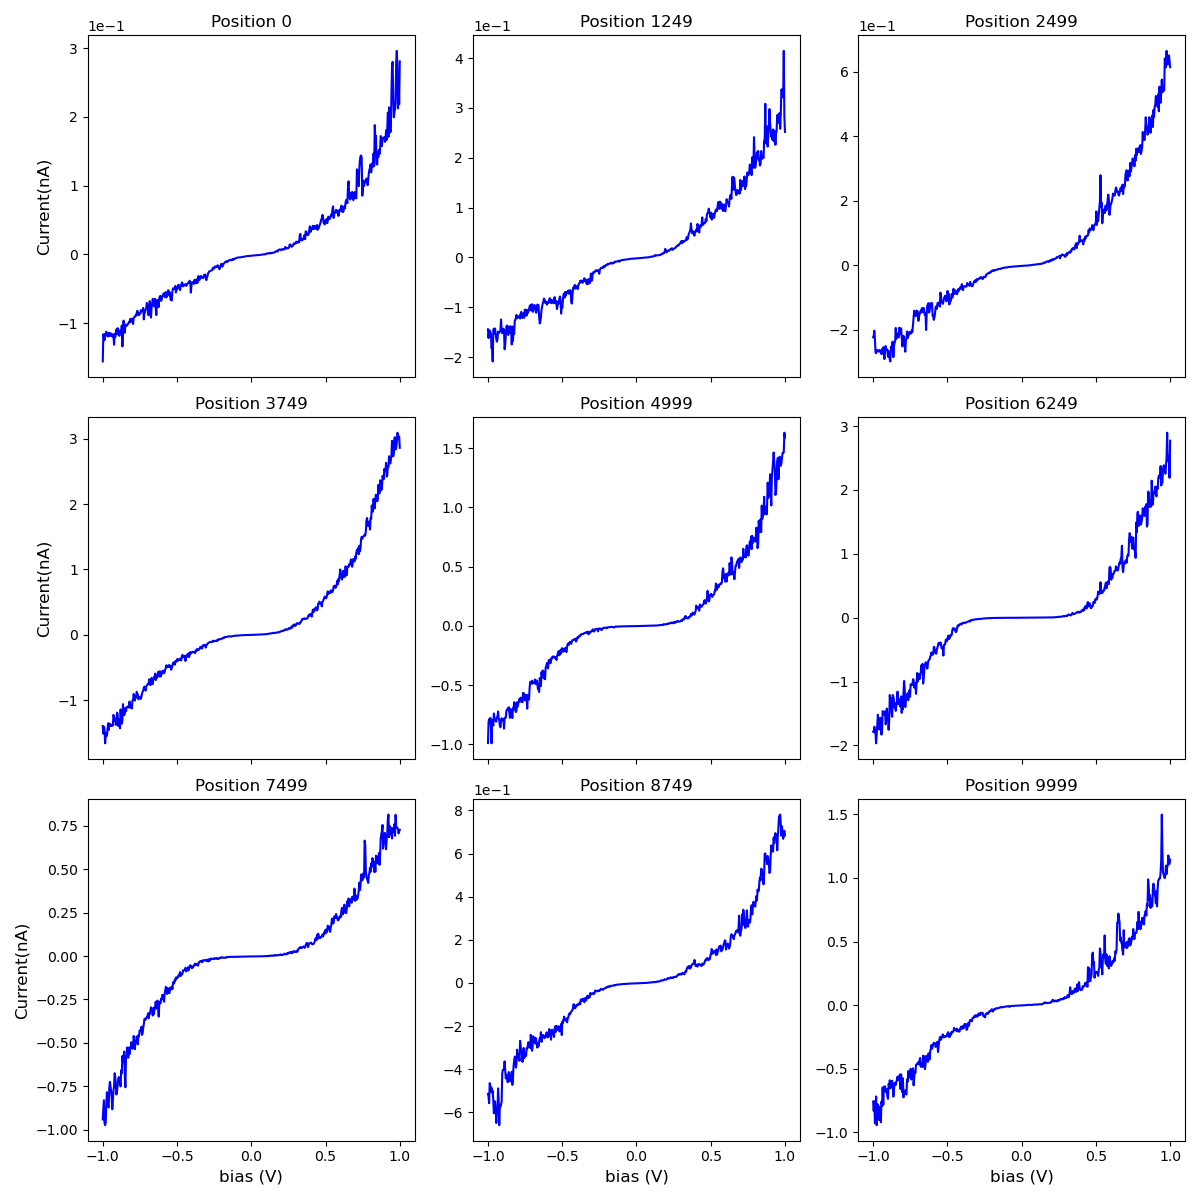

In [11]:
fig, axes = sidpy.plot_utils.plot_curves(bias_vec, raw_data_2d, num_plots=9,
                                        x_label='bias (V)',
                                        y_label=main_qty + '(' + main_units + ')',
                                        title='Current-Voltage Spectra at different locations',
                                        fig_title_yoffset=1.05)

Here is a visualization of spatial maps at different bias values

<IPython.core.display.Javascript object>


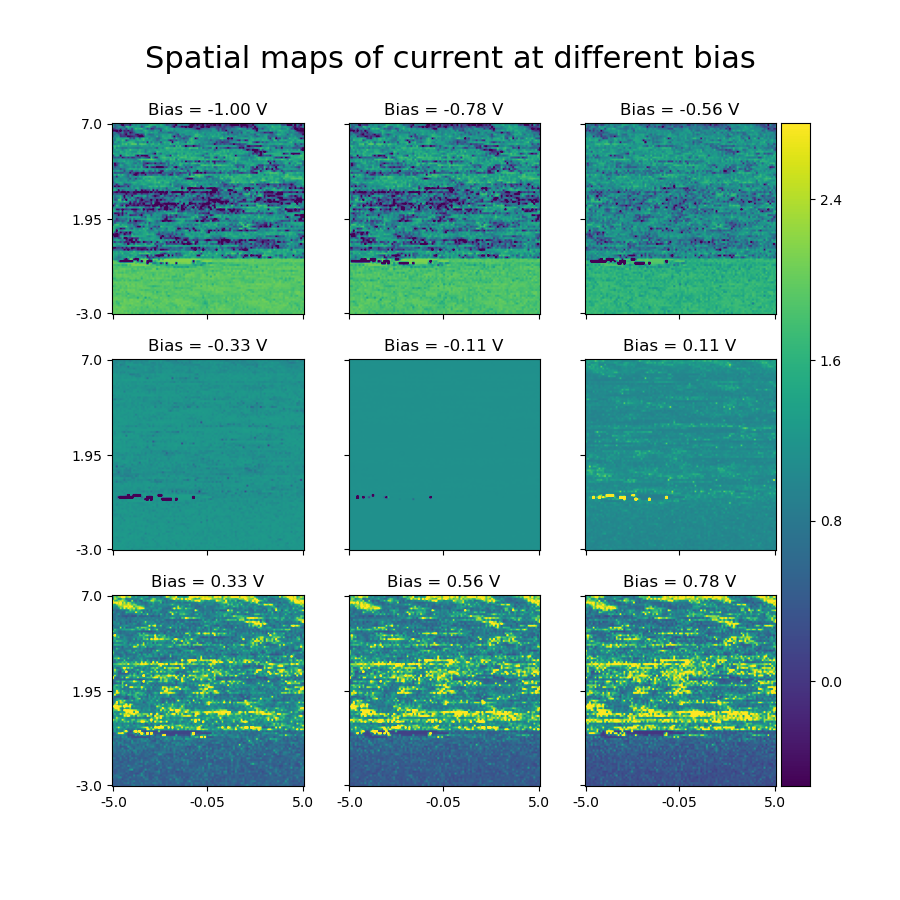

C:\ProgramData\Anaconda3\lib\site-packages\sidpy\viz\plot_utils\image.py:404: MatplotlibDeprecationWarning: Since 3.2, mpl_toolkits's own colorbar implementation is deprecated; it will be removed two minor releases later.  Set the 'mpl_toolkits.legacy_colorbar' rcParam to False to use Matplotlib's default colorbar implementation and suppress this deprecation warning.
  cb = axes.cbar_axes[0].colorbar(im)
C:\ProgramData\Anaconda3\lib\site-packages\mpl_toolkits\axes_grid1\axes_grid.py:51: MatplotlibDeprecationWarning: 
The mpl_toolkits.axes_grid1.colorbar module was deprecated in Matplotlib 3.2 and will be removed two minor releases later. Use matplotlib.colorbar instead.
  from .colorbar import Colorbar


In [12]:
fig, axes = sidpy.plot_utils.plot_map_stack(raw_data_3d, reverse_dims=True, pad_mult=(0.15, 0.15),
                                           title='Spatial maps of current at different bias', stdevs=2,
                                           color_bar_mode='single', num_ticks=3, x_vec=x_vec, y_vec=y_vec,
                                           evenly_spaced=True, fig_mult=(3, 3), title_yoffset=0.95)

for axis, bias_ind in zip(axes, np.linspace(0, len(bias_vec), 9, endpoint=False, dtype=np.uint)):
    axis.set_title('Bias = %3.2f V' % bias_vec[bias_ind])

## 2. Populating the ``Dataset`` object

Now that we are able to read the data from the Raw Data file, we can write this data into a ``sidpy.Dataset`` object

In [13]:
data_set = sidpy.Dataset.from_array(raw_data_3d, name='Raw_Data')
print(data_set)

sidpy.Dataset of type UNKNOWN with:
 dask.array<Raw_Data, shape=(100, 100, 500), dtype=float32, chunksize=(100, 100, 500), chunktype=numpy.ndarray>
 data contains: generic (generic)
 and Dimensions: 
  a:  generic (generic) of size (100,)
  b:  generic (generic) of size (100,)
  c:  generic (generic) of size (500,)


Now we specify the dimensions. Since ``data_set`` is a ``sidpy.Dataset`` object, we use the ``set_dimension`` method of ``sidpy`` to set the ``Dimension`` attributes.

In [14]:
data_set.set_dimension(0, sidpy.Dimension(y_vec, name='y',units='nm',
                                          quantity='Length',
                                          dimension_type='spatial'))
data_set.set_dimension(1, sidpy.Dimension(x_vec, name='x', units='nm',
                                          quantity='Length',
                                          dimension_type='spatial'))
data_set.set_dimension(2, sidpy.Dimension( bias_vec, name='bias',
                                          quantity='Bias',
                                          dimension_type='spectral'))

 Generic top level metadata can be added as you go along

In [15]:
data_set.data_type = sidpy.DataTypes.SPECTRAL_IMAGE
data_set.units = main_units
data_set.quantity = 'Current'

Instrument-specific metadata

In [16]:
data_set.metadata = parm_dict

Viewing the metadata

In [17]:
data_set.metadata

{'x-pixels': 100,
 'y-pixels': 100,
 'x-length': 29.7595,
 'y-length': 29.7595,
 'x-offset': -967.807,
 'y-offset': -781.441,
 'z-points': 500,
 'z-section': 491,
 'z-unit': 'nV',
 'z-range': 2000000000,
 'z-offset': 1116.49,
 'value-unit': 'nA',
 'scanspeed': 59519000000,
 'voidpixels': 0}

Visualize the ``Dataset`` object

<IPython.core.display.Javascript object>


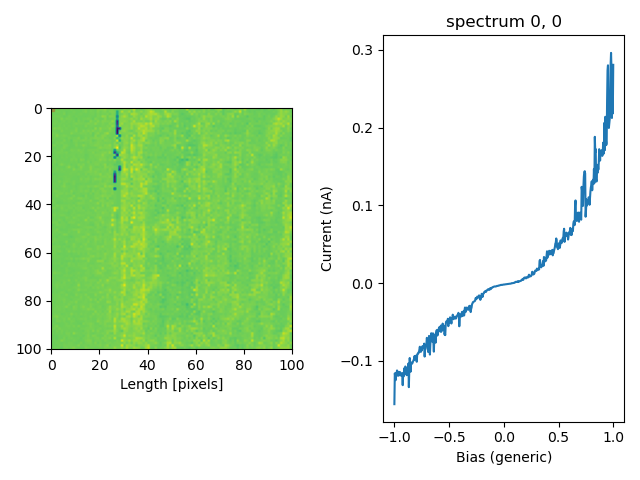

In [18]:
data_set.plot()

## 3. Creating a Reader Class 

Now that we learned how to populate the ``Dataset`` object with our raw data, we need to package this code into a class for code reusability. 

This is pretty simple. It is basically all the code above packaged into an ``ExampleReader`` class to make it easier for us to create simple ``ExampleReader`` Objects that can directly take the raw file as an input argument and read the data into a ``Dataset`` object. Using this class we can read similar data files with just 2 lines of code (as demonstrated later). 

Here, ``Examplereader`` extends ``sidpy.Reader`` class which is an abstract class that definces the most basic functionality of the data format Reader. We recommend extending the ``sidpy.Reader`` class while defining the data file reader class. This can significantly help with code debugging, if needed, later. 

In [19]:
class ExampleReader(sidpy.Reader):
    """
    The above definition of the class states that our ExampleReader inherits all the capabilities and
    behaviors of the Reader class in sidpy and builds on top of it
    """
        
    def read(self):
        """
        Extracts the data and metadata out of proprietary formatted files and writes it into a SID formatted HDF5 file

        
        Returns
        -------
        data_set: sidpy.Dataset object
            wraps all the raw data and metadata from the input file into a Dataset object
        """

        """
        --------------------------------------------------------------------------------------------
        1. Extracting data and metadata out of the proprietary file
        --------------------------------------------------------------------------------------------
        1.2 Read the contents of the file into memory
        """
        with open(self._input_file_path, 'r') as file_handle:
            string_lines = file_handle.readlines()

        """
        1.3 Extract all experiment and instrument related parameters
        """
        # Preparing an empty dictionary to store the metadata / parameters as key-value pairs
        parm_dict = dict()

        # Reading parameters stored in the first few rows of the file
        for line in string_lines[3:17]:
            line = line.replace('# ', '')
            line = line.replace('\n', '')
            temp = line.split('=')
            test = temp[1].strip()
            try:
                test = float(test)
                if test % 1 == 0:
                    test = int(test)
            except ValueError:
                pass
            parm_dict[temp[0].strip()] = test

        """
        1.4 Extract or generate parameters that define the three dimensions
        """
        num_rows = int(parm_dict['y-pixels'])
        num_cols = int(parm_dict['x-pixels'])
        num_pos = num_rows * num_cols
        spectra_length = int(parm_dict['z-points'])

        # We will assume that data was collected from -3 nm to +7 nm on the Y-axis or along the rows
        y_vec = np.linspace(-3, 7, num_rows, endpoint=True)

        # We will assume that data was collected from -5 nm to +5 nm on the X-axis or along the columns
        x_vec = np.linspace(-5, 5, num_cols, endpoint=True)

        # The bias was sampled from -1 to +1 V in the experiment. Here is how we generate the Bias axis:
        bias_vec = np.linspace(-1, 1, spectra_length)

        """
        1.5 Extract the data
        """
        num_headers = 403

        raw_data_2d = np.zeros(shape=(num_pos, spectra_length), dtype=np.float32)

        # Iterate over every measurement position:
        for pos_index in range(num_pos):
            this_line = string_lines[num_headers + pos_index]
            string_spectrum = this_line.split('\t')[:-1]  # omitting the new line
            raw_data_2d[pos_index] = np.array(string_spectrum, dtype=np.float32)


        """
        --------------------------------------------------------------------------------------------
        2. Writing the data into a sidpy.Dataset object called data_set
        --------------------------------------------------------------------------------------------
        2.1 Writing the raw data
        """
        data_set = sidpy.Dataset.from_array(raw_data_3d, name='Raw_Data')

        """
        2.2 Writing the metadata
        """
        data_set.metadata = parm_dict
        
        """
        2.3 Writing the dimensions
        """
        data_set.set_dimension(0, sidpy.Dimension(y_vec, name='y',units='nm',
                                          quantity='Length',
                                          dimension_type='spatial'))
        data_set.set_dimension(1, sidpy.Dimension(x_vec, name='x', units='nm',
                                          quantity='Length',
                                          dimension_type='spatial'))
        data_set.set_dimension(2, sidpy.Dimension( bias_vec, name='bias',
                                          quantity='Bias',
                                          dimension_type='spectral'))
        return data_set
    
    def can_read(self):
        """
        Tests whether or not the provided file has .asc extension
        
        Returns
        -------
        """

        return super(ExampleReader, self).can_read(extension='asc')

### Using the ``ExampleReader``
What we did above is provide a template for what should happen when someone provides an input file. We have not really tried it out yet. The lines below will illustrate how easy it becomes to read data from the input file now using this ``ExampleReader`` class:

In [20]:
# instantiate the class first:
my_reader = ExampleReader(data_file_path)

# Then call the read function:
my_data=my_reader.read()

Setting the generic top level metadata manually

In [21]:
my_data.data_type = sidpy.DataTypes.SPECTRAL_IMAGE
my_data.units = main_units
my_data.quantity = 'Current'
my_data.bias.units='V'

In [22]:
print(my_data)

sidpy.Dataset of type SPECTRAL_IMAGE with:
 dask.array<Raw_Data, shape=(100, 100, 500), dtype=float32, chunksize=(100, 100, 500), chunktype=numpy.ndarray>
 data contains: Current (nA)
 and Dimensions: 
  y:  Length (nm) of size (100,)
  x:  Length (nm) of size (100,)
  bias:  Bias (V) of size (500,)
 with metadata: ['x-pixels', 'y-pixels', 'x-length', 'y-length', 'x-offset', 'y-offset', 'z-points', 'z-section', 'z-unit', 'z-range', 'z-offset', 'value-unit', 'scanspeed', 'voidpixels']


Viewing the data

<IPython.core.display.Javascript object>


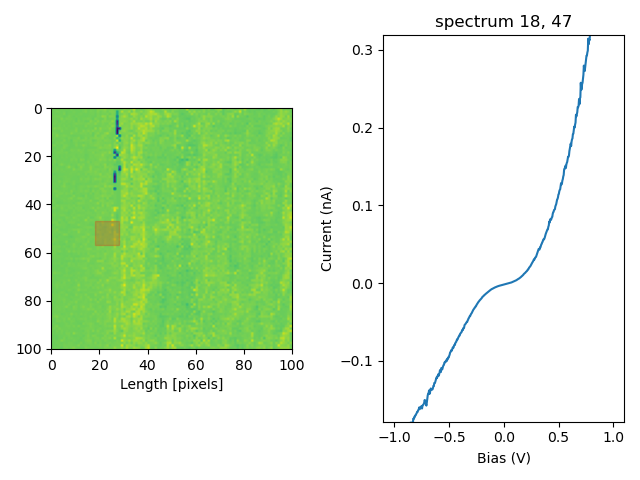

In [23]:
my_data.plot()

We can also bin the data for viewing. Let us try viewing the data as 10 X 10 pixel size

In [24]:
my_data.view.set_bin([10, 10])
my_data.plot()

### Cleaning up
Remove the original data file to free up space:

In [25]:
os.remove(data_file_path)

### More information

``sidpy`` package is used to create the ``Dataset`` object in this example. This package provides utilities for storing, processing and visualizing spectroscopic and imaging data. 
It is recommended the user familiarize themselves with ``sidpy``. These example `notebooks <https://github.com/pycroscopy/sidpy/tree/master/notebooks>`_ demonstrate how to create and visualize ``Dataset`` objects.

Our sister class - pycroscopy, has several
`translators <https://github.com/pycroscopy/pycroscopy/tree/master/pycroscopy/io/translators>`_ that translate popular
file formats generated by nanoscale imaging instruments.
These will be moved to ScopeReaders soon

We have found python packages online to open a few proprietary file formats and have written translators using these
packages. If you are having trouble reading the data in your files and cannot find any packages online, consider
contacting the manufacturer of the instrument which generated the data in the proprietary format for help.

